In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

%matplotlib inline

##  The Novel Coronavirus: Data Science and Machine Learning Visualizations

This is the site where I pull the recent `.csv` files: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

Formats of the `.csv` files are bound to change.

Also trying to find ways to automatically pull the dataset, if possible

This notebook uses the confimed, deaths, and recovered database

In [2]:
!ls

COVID19 Visualizations.ipynb README.md
COVID19_databases            graphs_by_countries
COVID19_worldwide.png        graphs_by_countries_legend
Icon?


In [3]:
"""
Load the CSV files. Please make sure to pull the latest files from the website
Directories and archives as well will be stored in COVID19_databases/ (As of April 2nd)
"""
COVID19_confirmed = pd.read_csv("COVID19_databases/time_series_covid19_confirmed_global.csv")
COVID19_deaths = pd.read_csv("COVID19_databases/time_series_covid19_deaths_global.csv")
COVID19_recovered = pd.read_csv("COVID19_databases/time_series_covid19_recovered_global.csv")

In [4]:
COVID19_confirmed.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,120,170,174,237,273,281,299,349,367,423
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,212,223,243,259,277,304,333,361,377,383
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,511,584,716,847,986,1171,1251,1320,1423,1468
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,334,370,376,390,428,439,466,501,525,545
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,7,7,7,8,8,8,10,14,16,17
5,NaN,Antigua and Barbuda,17.0608,-61.7964,0,0,0,0,0,0,...,7,7,7,7,9,15,15,15,15,19
6,NaN,Argentina,-38.4161,-63.6167,0,0,0,0,0,0,...,745,820,1054,1054,1133,1265,1451,1451,1554,1628
7,NaN,Armenia,40.0691,45.0382,0,0,0,0,0,0,...,424,482,532,571,663,736,770,822,833,853
8,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,77,78,80,84,87,91,93,96,96,96
9,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,1791,2032,2032,2182,2298,2389,2493,2580,2637,2686


In [5]:
#Lat and Long data could be used later or map visualization
COVID19_confirmed = COVID19_confirmed.drop(['Lat', 'Long'], axis=1)
COVID19_deaths = COVID19_deaths.drop(['Lat', 'Long'], axis=1)
COVID19_recovered = COVID19_recovered.drop(['Lat', 'Long'], axis=1)

I don't know how to filter out the NaN for smaller countries for no provinces/states, so I split the data into two sections between big countries and small countries helper functions. Everything should work smoothly.

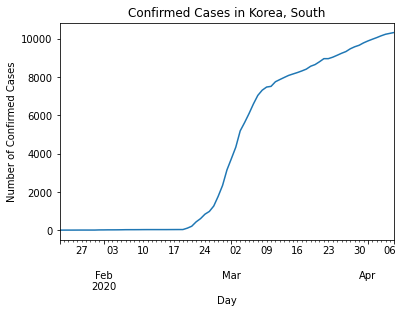

In [6]:
def country(country_name, data):
    country = data
    country = country.pivot_table(index=['Country/Region'])
    country.columns = pd.to_datetime(country.columns)
    country = country.groupby(level=[0], sort=False).sum()
    country = country.loc[country_name]
    country = country.sort_index().plot()
    
    if data.equals(COVID19_confirmed):
        dataType = "Confirmed Cases"
    elif data.equals(COVID19_recovered):
        dataType = "Recovered"
    elif data.equals(COVID19_deaths):
        dataType = "Deaths"
    
    #Labelings
    country.set_ylabel("Number of " + dataType)
    country.set_xlabel("Day")
    country.set_title(dataType + " in " + country_name)
    return country
    
country("Korea, South", COVID19_confirmed)

In [7]:
#Saves each graph for each country. Takes a long time to run and save (around 5 minutes)
def updateAllCountryGraphs():
    all_countries = list(COVID19_confirmed['Country/Region'])
    all_countries = list(dict.fromkeys(all_countries))
    data = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]
    
    for Country in all_countries:
        for dataType in data:
            country(Country, dataType[0])
            plt.savefig("graphs_by_countries/" + Country + "_" + dataType[1] + ".png")
            plt.tight_layout()
            plt.clf()
            
updateAllCountryGraphs()

<Figure size 432x288 with 0 Axes>

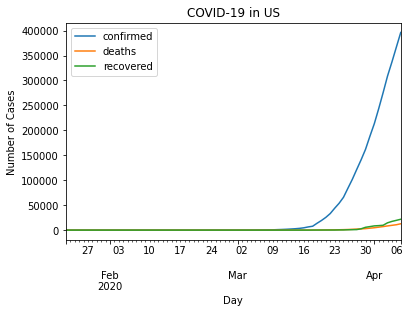

In [8]:
dataset = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]

def small_country_legend(country_name):
    for data in dataset:
        country = data[0]
        country = country.pivot_table(index=['Country/Region'])
        country.columns = pd.to_datetime(country.columns)
        country = country.groupby(level=[0], sort=False).sum()
        country = country.loc[country_name]
        country = country.sort_index().plot(label=data[1])
    
    #Labelings
    country.set_ylabel("Number of Cases")
    country.set_xlabel("Day")
    country.set_title("COVID-19 in " + country_name)
    country.legend()
    return country 

def big_country_legend(country_name):
    for data in dataset:
        country = data[0]
        country = country.pivot_table(index=['Country/Region', 'Province/State'])
        country.columns = pd.to_datetime(country.columns)
        country = country.groupby(level=[0], sort=False).sum()
        country = country.loc[country_name]
        country = country.sort_index().plot(label=data[1])

    #Labelings
    country.set_ylabel("Number of Cases")
    country.set_xlabel("Day")
    country.set_title("COVID-19 in " + country_name)
    country.legend()
    return country 

def country_legend(country_name):
    big_countries = [] #['Australia', 'Canada', 'China', 'Cruise Ship', 
                       #'Denmark', 'France', 'Netherlands', 'US', 'United Kingdom']
    if country_name in big_countries:
        return big_country_legend(country_name)
    else:
        return small_country_legend(country_name)
    
country_legend('US')

In [9]:
def updateAllCountryGraphsLegend():
    all_countries = list(COVID19_confirmed['Country/Region'])
    all_countries = list(dict.fromkeys(all_countries))
    
    for Country in all_countries:
        country_legend(Country)
        plt.savefig("graphs_by_countries_legend/" + Country + "_all.png")
        plt.tight_layout()
        plt.clf()
            
updateAllCountryGraphsLegend()

<Figure size 432x288 with 0 Axes>

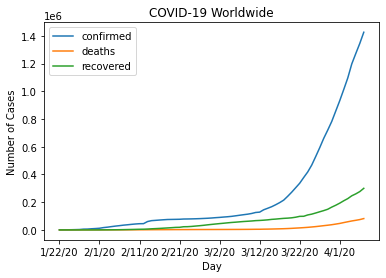

In [10]:
allCountries_confirmed = COVID19_confirmed.drop(['Country/Region', 'Province/State'], axis=1).sum()
allCountries_deaths = COVID19_deaths.drop(['Country/Region', 'Province/State'], axis=1).sum()
allCountries_recovered = COVID19_recovered.drop(['Country/Region', 'Province/State'], axis=1).sum()

def allCountries():
    world = allCountries_confirmed.plot(label="confirmed")
    world = allCountries_deaths.plot(label="deaths")
    world = allCountries_recovered.plot(label="recovered")
    
    #Labelings
    world.set_ylabel("Number of Cases")
    world.set_xlabel("Day")
    world.set_title("COVID-19 Worldwide")
    world.legend()
    plt.savefig("COVID19_worldwide")
    return world

allCountries()

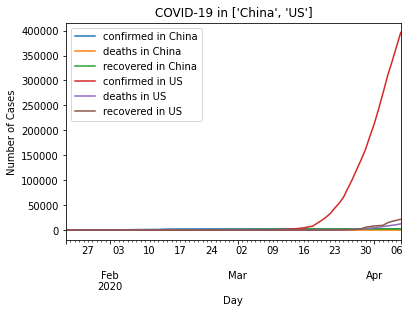

In [11]:
dataset = [(COVID19_confirmed, "confirmed"), (COVID19_deaths, "deaths"), (COVID19_recovered, "recovered")]

def customCountries(list_countries):
    
    for Country in list_countries:
        for data in dataset:
            country = data[0]
            country = country.pivot_table(index=['Country/Region'])
            country.columns = pd.to_datetime(country.columns)
            country = country.groupby(level=[0], sort=False).sum()
            country = country.loc[Country]
            country = country.sort_index().plot(label=data[1] + " in " + str(Country))
    
    country.set_ylabel("Number of Cases")
    country.set_xlabel("Day")
    country.set_title("COVID-19 in " + str(list(list_countries)))
    country.legend()

        
    #plt.savefig(str(list_countries) + ".png")
    
customCountries(['China', 'US'])
